#### TF.Snoqualmie_Tsurf.ipynb
Karl Lapo October/2015

Exploring Tsurface from Snoqualmie


In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('talk')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Solargeometry
import solargeo

## Directory listing
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/YosemiteIR/Graphics'
dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'

/Users/karllapo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
## Load data
os.chdir(dir_data)
ds = xray.open_dataset('SnoqualmieObs.wy2013.wy2015.nc')
print(ds)

<xray.Dataset>
Dimensions:  (time: 45741)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01 2012-10-01T00:30:00 ...
Data variables:
    precip   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SWdwn    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    LWdwn    (time) float64 286.9 286.9 286.5 286.5 286.5 286.5 286.5 286.5 ...
    Tair     (time) float64 279.0 279.0 279.0 279.2 279.4 279.4 279.1 278.9 ...
    WIND     (time) float64 0.068 0.126 0.06 0.126 0.045 0.099 0.199 0.116 ...
    Press    (time) float64 9.088e+04 9.086e+04 9.085e+04 9.085e+04 ...
    QS       (time) float64 0.005277 0.005341 0.005394 0.005419 0.005373 ...
    RH       (time) float64 83.35 84.34 85.05 84.36 82.46 83.76 84.16 84.74 ...
    Tdew     (time) float64 3.24 3.407 3.546 3.611 3.49 3.661 3.512 3.409 ...
    Tsurf    (time) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...


In [3]:
############################################################################
## Functions
############################################################################

In [4]:
## These still require some testing to make sure they are physical...
def stability(Tair,Tsurf,U,z=2):
    g = 9.81
    Ri = g*z*(Tair-Tsurf)/(.5*(Tair+Tsurf)*U**2)
    return(Ri)
    
def cloudiness(LWdwn,Tair,k=.5,e_AD=.22):
    sigma = 5.67*10**(-8)
    e_A = LWdwn/(sigma*Tair**4)
    e_AC = e_AD + k*(e_A/Tair)**(1/8)
    cloud_index = e_A/e_AC
    return(cloud_index)

Ri = stability(ds.Tair.values,ds.Tsurf.values+273.16,ds.WIND.values,z=3)
ds['Ri'] = (('time'),Ri)
CI = cloudiness(ds.LWdwn.values,ds.Tair.values)
print(ds)

<xray.Dataset>
Dimensions:  (time: 45741)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01 2012-10-01T00:30:00 ...
Data variables:
    precip   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SWdwn    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    LWdwn    (time) float64 286.9 286.9 286.5 286.5 286.5 286.5 286.5 286.5 ...
    Tair     (time) float64 279.0 279.0 279.0 279.2 279.4 279.4 279.1 278.9 ...
    WIND     (time) float64 0.068 0.126 0.06 0.126 0.045 0.099 0.199 0.116 ...
    Press    (time) float64 9.088e+04 9.086e+04 9.085e+04 9.085e+04 ...
    QS       (time) float64 0.005277 0.005341 0.005394 0.005419 0.005373 ...
    RH       (time) float64 83.35 84.34 85.05 84.36 82.46 83.76 84.16 84.74 ...
    Tdew     (time) float64 3.24 3.407 3.546 3.611 3.49 3.661 3.512 3.409 ...
    Tsurf    (time) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    Ri       (time) float64 nan nan nan nan nan nan nan nan nan nan nan n

(0, 23)

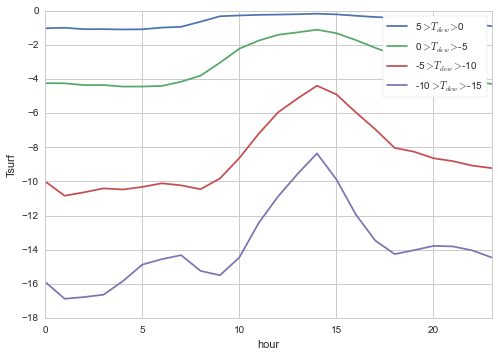

In [5]:
#### Tsurf - daily composite by dew point
Tdew_thresh = np.array((5,0,-5,-10,-15))
Tdew = ds.Tdew.resample(freq='d',dim='time',how='mean',label='right').reindex(time=ds.time,method='bfill')

# Composire Tsurf
for td_up,td_low in zip(Tdew_thresh[0:-1],Tdew_thresh[1:]):
    ds.Tsurf.sel(time=(Tdew<td_up) & (Tdew>td_low)).\
                 groupby('time.hour').mean('time').plot(label=str(td_up)+'$ > T_{dew} > $'+str(td_low))
plt.legend(frameon=True)
ax = plt.gca()
ax.set_xlim(0,23)

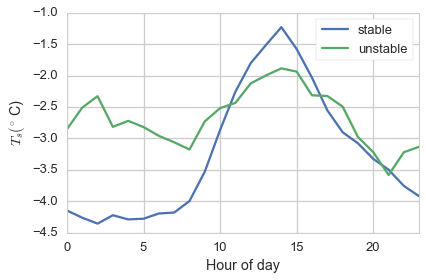

In [9]:
#### Tsurf - daily composite by stability
Ri_thresh = .2

fig,ax = plt.subplots(1,1,figsize=(6,4))

# Composite Tsurf (stable)
plt.plot(np.arange(0,24),ds.Tsurf.sel(time=(ds.Ri > Ri_thresh)).groupby('time.hour').mean('time'),label='stable')
plt.plot(np.arange(0,24),ds.Tsurf.sel(time=(ds.Ri <= Ri_thresh)).groupby('time.hour').mean('time'),label='unstable')

ax.legend(loc='best',frameon=True)
ax.set_xlim(0,23)
ax.set_xlabel('Hour of day')
ax.set_ylabel('$ T_{s} (^{\circ}$ C)')


os.chdir(dir_print)
fig.tight_layout()
fig.savefig('SNQ.Ts.DiurnalComposite.pdf')

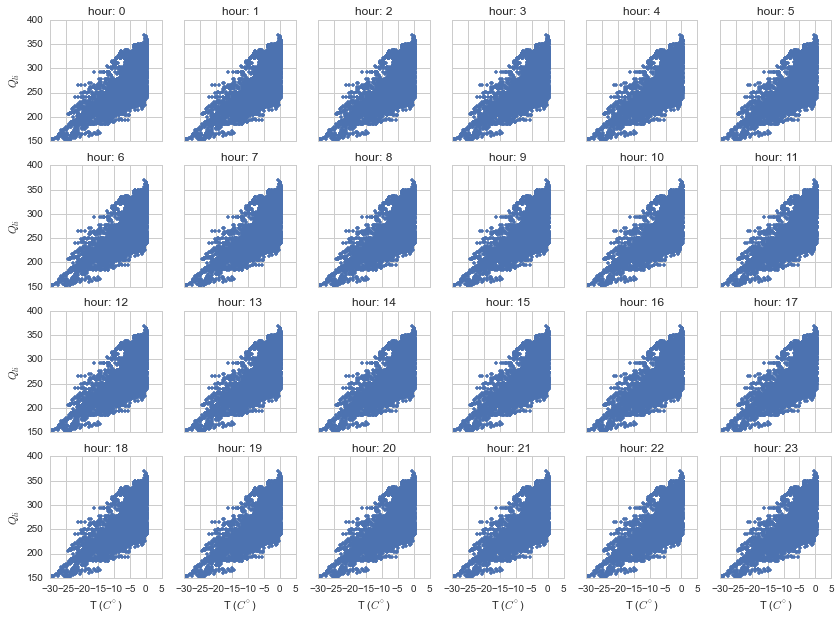

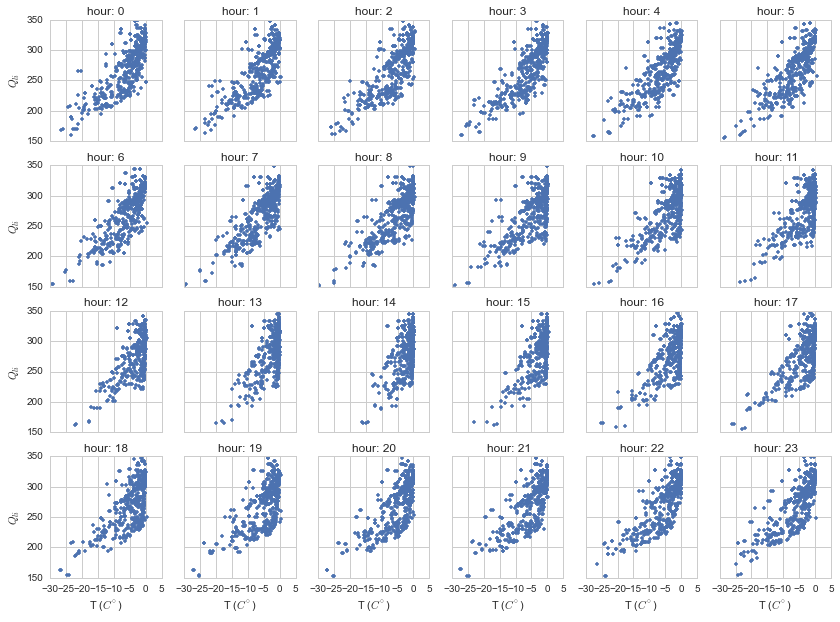

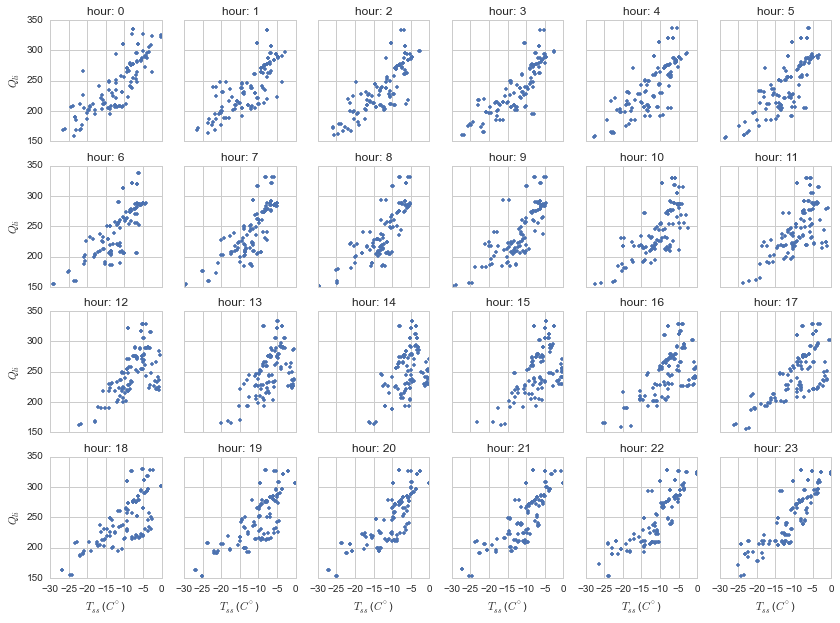

In [7]:
## All Tsurf < 0
fig,axes = plt.subplots(4,6,sharey='row',sharex='col',figsize=(14,10))
axes = axes.flatten()
for hh in np.arange(0,24):
    ax = axes[hh]
    ts = ds.Tsurf.sel(ds['time.hour'] == hh)
    lwdwn = ds.LWdwn.sel(ds['time.hour'] == hh)
    ax.plot(ts,lwdwn,'.')
    ax.set_title('hour: '+str(hh))
    if np.fmod(hh,6) == 0:
        ax.set_ylabel('$Q_{li}$')
    if hh >= 18:
        ax.set_xlabel('T ($C^{\circ}$)')
        
## Tdew < 0
fig,axes = plt.subplots(4,6,sharey='row',sharex='col',figsize=(14,10))
axes = axes.flatten()
for hh in np.arange(0,24):
    ax = axes[hh]
    ts = ds.Tsurf.sel(time=(Tdew<0) & (ds['time.hour'] == hh))
    lwdwn = ds.LWdwn.sel(time=(Tdew<0) & (ds['time.hour'] == hh))
    ax.plot(ts,lwdwn,'.')
    ax.set_title('hour: '+str(hh))
    if np.fmod(hh,6) == 0:
        ax.set_ylabel('$Q_{li}$')
    if hh >= 18:
        ax.set_xlabel('T ($C^{\circ}$)')

## Tdew < -5
fig,axes = plt.subplots(4,6,sharey='row',sharex='col',figsize=(14,10))
axes = axes.flatten()
for hh in np.arange(0,24):
    ax = axes[hh]
    ts = ds.Tsurf.sel(time=(Tdew<-5) & (ds['time.hour'] == hh))
    lwdwn = ds.LWdwn.sel(time=(Tdew<-5) & (ds['time.hour'] == hh))
    ax.plot(ts,lwdwn,'.')
    ax.set_title('hour: '+str(hh))
    if np.fmod(hh,6) == 0:
        ax.set_ylabel('$Q_{li}$')
    if hh >= 18:
        ax.set_xlabel('$T_{ss}$ ($C^{\circ}$)')

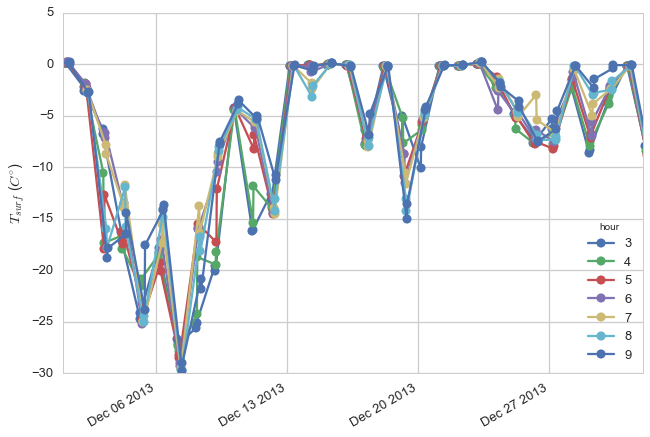

In [24]:
fig,ax = plt.subplots(1,1)
for hh in np.arange(3,10):
    plt.plot(ds.time.sel(time=(ds['time.hour'] == hh)),\
             ds.Tsurf.sel(time=(ds['time.hour'] == hh)),\
             '-o',label=str(hh))
ax.set_xlim(datetime(2013,12,1),datetime(2014,1,1))
ax.legend(loc='best',title='hour')
ax.set_ylabel('$T_{surf}$ ($C^{\circ}$)')
fig.autofmt_xdate()

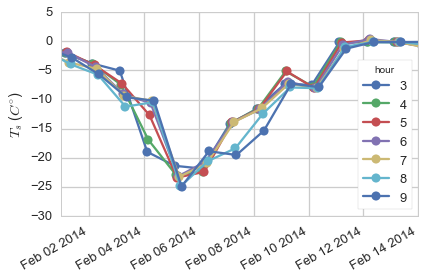

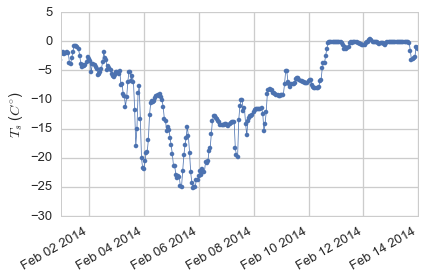

In [25]:
# Ts time of day influence
fig,ax = plt.subplots(1,1,figsize=(6,4))
Ts = ds.Tsurf.resample(freq='H',how='mean',dim='time')
for hh in np.arange(3,10):
    plt.plot(Ts.time.sel(time=(Ts['time.hour'] == hh)),\
             Ts.sel(time=(Ts['time.hour'] == hh)),\
             '-o',label=str(hh))

ax.set_xlim(datetime(2014,2,1),datetime(2014,2,14))
ax.legend(loc='best',title='hour',frameon=True)
ax.set_ylabel('$T_{s}$ ($C^{\circ}$)')
fig.autofmt_xdate()

os.chdir(dir_print)
fig.tight_layout()
fig.savefig('SNQ.Ts_SampleTime.Feb2014.pdf')

# Ts time series
fig,ax = plt.subplots(1,1,figsize=(6,4))
plt.plot(Ts.time,Ts,marker='.',lw=.75)

ax.set_xlim(datetime(2014,2,1),datetime(2014,2,14))
ax.set_ylabel('$T_{s}$ ($C^{\circ}$)')
fig.autofmt_xdate()

os.chdir(dir_print)
fig.tight_layout()
fig.savefig('SNQ.Ts.Feb2014.pdf')

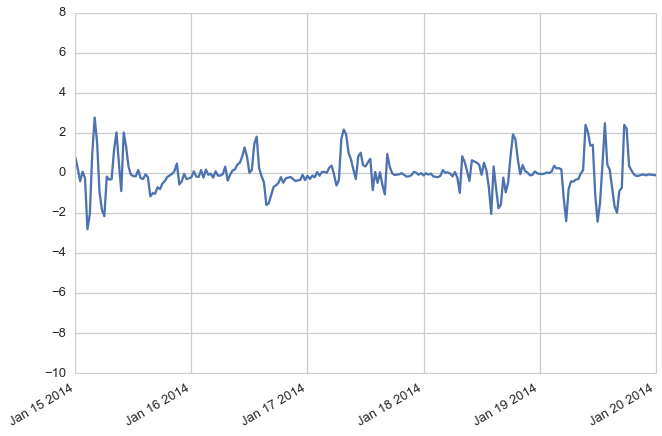

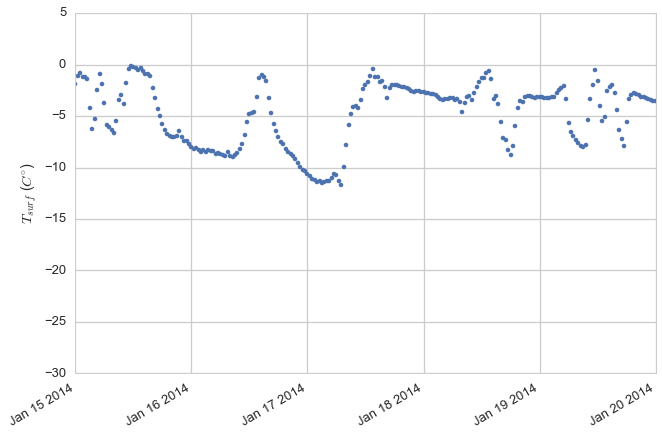

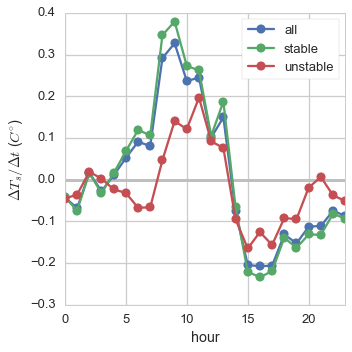

In [19]:
dTs_dt = ds.Tsurf.values[1:]-ds.Tsurf.values[0:-1]
dTs_dt = np.append(dTs_dt,np.nan)
ds['dTsdt'] = (('time'),dTs_dt)

fig,ax = plt.subplots(1,1)
plt.plot(ds.time,dTs_dt)
ax.set_xlim(datetime(2014,1,15),datetime(2014,1,20))
# ax.set_ylabel('$T_{surf}$ ($C^{\circ}$)')
fig.autofmt_xdate()

fig,ax = plt.subplots(1,1)
plt.plot(ds.time,ds.Tsurf,'.')
ax.set_xlim(datetime(2014,1,15),datetime(2014,1,20))
ax.set_ylabel('$T_{surf}$ ($C^{\circ}$)')
fig.autofmt_xdate()

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.array((0,25)),np.array((0,0)),'-',color='.75',lw=3)
ds.dTsdt.groupby('time.hour').mean('time').plot(label='all',marker='o')
ds.dTsdt.sel(time = ds.Ri > .2).groupby('time.hour').mean('time').plot(label='stable',marker='o')
ds.dTsdt.sel(time = ds.Ri <= .2).groupby('time.hour').mean('time').plot(label='unstable',marker='o')
ax.legend(frameon=True)
ax.set_ylabel(r'$\Delta T_{s}/ \Delta t$ ($C^{\circ}$)')
ax.set_xlim(0,23)

fig.tight_layout()
os.chdir(dir_print)
plt.savefig('SNQ.dTdt.pdf')